In [1]:

# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.16.1
GPU Available: []


In [2]:
print("Loading data...")
train_data = pd.read_csv('data_minihackathon_train.csv')
test_data = pd.read_csv('data_minihackathon_test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nTraining data info:")
print(train_data.info())
print(f"\nMissing values in training data:")
print(train_data.isnull().sum())

Loading data...
Training data shape: (1500, 14)
Test data shape: (377, 13)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1500 non-null   int64  
 1   Age            1498 non-null   float64
 2   Gender         1499 non-null   float64
 3   Education      1480 non-null   float64
 4   Country        1498 non-null   float64
 5   Ethnicity      1500 non-null   float64
 6   Nscore         1499 non-null   float64
 7   Escore         1499 non-null   float64
 8   Oscore         1499 non-null   float64
 9   Ascore         1499 non-null   float64
 10  Cscore         1499 non-null   float64
 11  Impulsive      1499 non-null   float64
 12  SS             1500 non-null   float64
 13  drug_category  1500 non-null   object 
dtypes: float64(12), int64(1), object(1)
memory usage: 164.2+ KB
None

Missing values in trai

In [3]:
# Cell 3: Exploratory Data Analysis
print("\nTarget distribution:")
print(train_data['drug_category'].value_counts())


Target distribution:
drug_category
Hallucinogens    691
Stimulants       567
Depressants      242
Name: count, dtype: int64


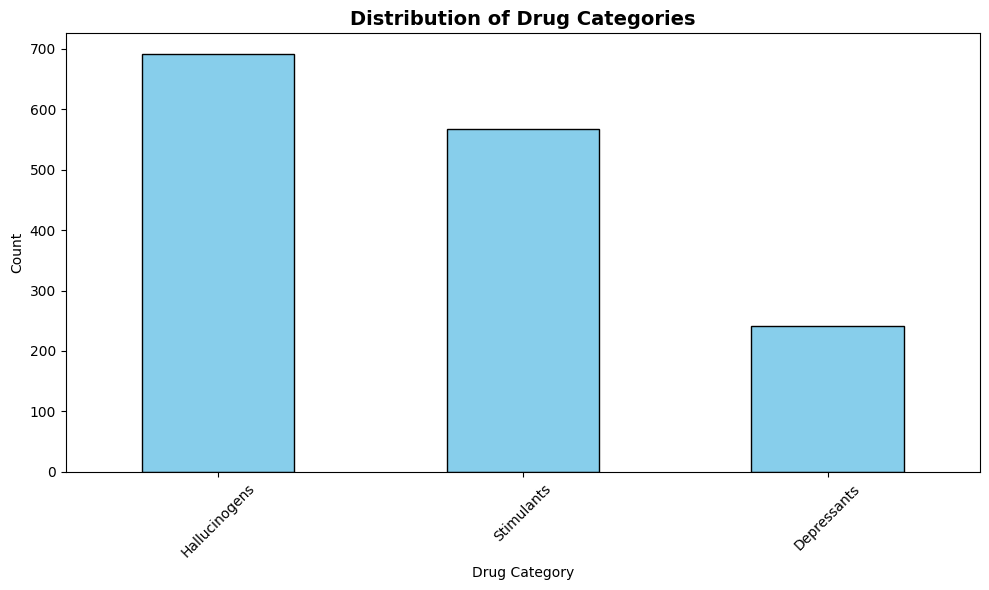

In [4]:
# Plot target distribution
plt.figure(figsize=(10, 6))
train_data['drug_category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Drug Categories', fontsize=14, fontweight='bold')
plt.xlabel('Drug Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Cell 4: Data Preprocessing
# Separate features and target
X = train_data.drop(['ID', 'drug_category'], axis=1)
y = train_data['drug_category']
X_test = test_data.drop(['ID'], axis=1)
test_ids = test_data['ID']

In [6]:
print(f"Features shape: {X.shape}")
print(f"Features: {list(X.columns)}")

Features shape: (1500, 12)
Features: ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']


In [7]:
print("\nHandling missing values...")
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print(f"Missing values after imputation: {X_imputed.isnull().sum().sum()}")


Handling missing values...
Missing values after imputation: 0


In [8]:
# Cell 5: Encode Target Variable
# Encode target labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Encoding mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name} -> {i}")

Number of classes: 3
Classes: ['Depressants' 'Hallucinogens' 'Stimulants']
Encoding mapping:
  Depressants -> 0
  Hallucinogens -> 1
  Stimulants -> 2


In [9]:
# Cell 6: Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_imputed, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())

Training set size: 1350
Validation set size: 150

Training set class distribution:
0    218
1    622
2    510
Name: count, dtype: int64


In [ ]:
# # Cell 7: Feature Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test_imputed)

# print(f"Scaled training data shape: {X_train_scaled.shape}")
# print(f"Feature mean after scaling: {X_train_scaled.mean():.6f}")
# print(f"Feature std after scaling: {X_train_scaled.std():.6f}")
from imblearn.over_sampling import SMOTE

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

Scaled training data shape: (1350, 12)
Feature mean after scaling: 0.000000
Feature std after scaling: 1.000000


In [11]:
# Cell 8: Build Neural Network Model
def create_model(input_dim, num_classes, learning_rate=0.001):
    model = models.Sequential([
        # Input layer
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Hidden layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
input_dim = X_train_scaled.shape[1]
model = create_model(input_dim, num_classes)

# Display model architecture
print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,739 (81.01 KB)

 Trainable params: 20,163 (78.76 KB)

 Non-trainable params: 576 (2.25 KB)

In [12]:
# Cell 9: Setup Callbacks
# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when learning plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint to save best model
checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callback_list = [early_stopping, reduce_lr, checkpoint]

In [13]:
# Cell 10: Train Model
print("Training Neural Network...")
print("="*10)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callback_list,
    verbose=1
)

print("\n✓ Training completed!")

Training Neural Network...
Epoch 1/100
30/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3744 - loss: 1.3729
Epoch 1: val_accuracy improved from -inf to 0.64667, saving model to best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3986 - loss: 1.3252 - val_accuracy: 0.6467 - val_loss: 0.9999 - learning_rate: 0.0010
Epoch 2/100
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5781 - loss: 1.0277
Epoch 2: val_accuracy improved from 0.64667 to 0.67333, saving model to best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5828 - loss: 1.0165 - val_accuracy: 0.6733 - val_loss: 0.9491 - learning_rate: 0.0010
Epoch 3/100
23/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6598 - loss: 0.8617 
Epoch 3: val_accuracy improved from 0.67333 to 0.68667, saving model to best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6555 - loss: 0.8670 - val_accuracy: 0.6867 - val_loss: 0.9255 - learning_rate: 0.0010
Epoch 4/100
22/43 ━━━━━━━━━━━━━━━━━

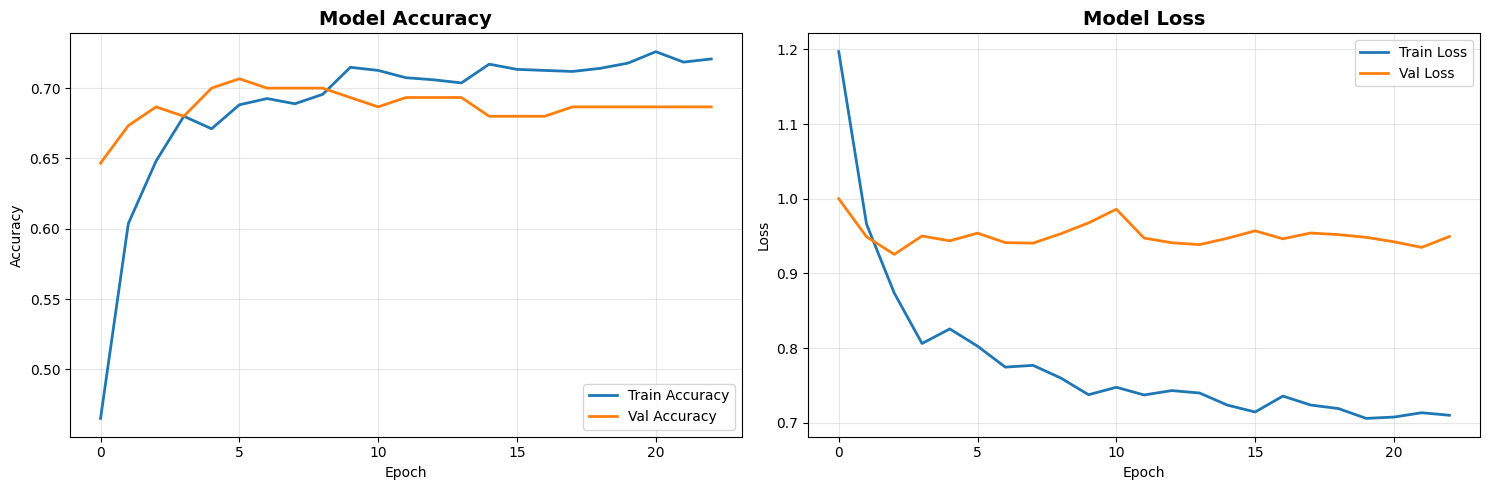

In [14]:
# Cell 11: Plot Training History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:

# Cell 12: Evaluate Model
# Load best model
model = keras.models.load_model('best_model.keras')

# Predictions on validation set
y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Validation Accuracy: 0.7067 (70.67%)


In [16]:
# Classification report
print("\n" + "="*60)
print("Classification Report")
print("="*60)
print(classification_report(
    y_val, y_val_pred,
    target_names=label_encoder.classes_
))


Classification Report
               precision    recall  f1-score   support

  Depressants       0.50      0.04      0.08        24
Hallucinogens       0.72      0.88      0.79        69
   Stimulants       0.70      0.77      0.73        57

     accuracy                           0.71       150
    macro avg       0.64      0.57      0.53       150
 weighted avg       0.68      0.71      0.66       150



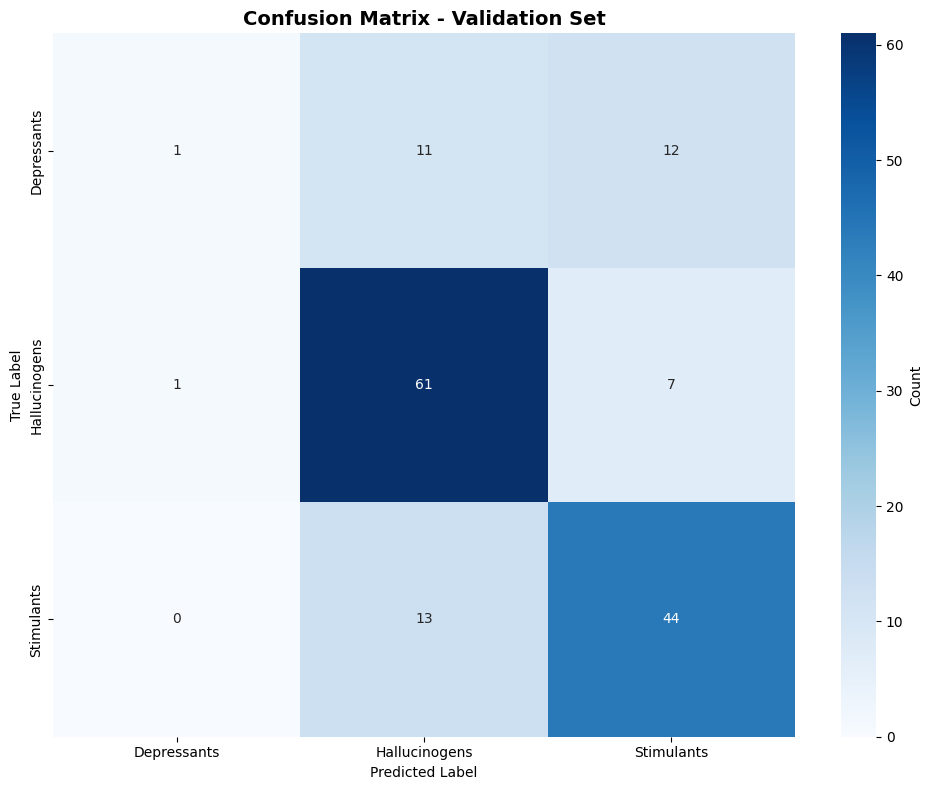

In [17]:
# Cell 13: Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [18]:
# Cell 14: Per-Class Accuracy
print("\nPer-Class Accuracy:")
print("-" * 40)
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_val == i
    if class_mask.sum() > 0:
        class_acc = (y_val_pred[class_mask] == i).mean()
        print(f"{class_name:20} {class_acc:.4f} ({class_acc*100:.2f}%)")


Per-Class Accuracy:
----------------------------------------
Depressants          0.0417 (4.17%)
Hallucinogens        0.8841 (88.41%)
Stimulants           0.7719 (77.19%)


In [19]:
# Cell 15: Make Predictions on Test Set
print("\nMaking predictions on test set...")
test_predictions_probs = model.predict(X_test_scaled)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# Decode predictions back to original labels
test_predictions_decoded = label_encoder.inverse_transform(test_predictions)

print(f"Test predictions shape: {test_predictions.shape}")


Making predictions on test set...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
Test predictions shape: (377,)


In [20]:
# Cell 16: Create Submission File
submission = pd.DataFrame({
    'ID': test_ids,
    'drug_category': test_predictions_decoded
})

In [21]:
submission.to_csv('predictions1.csv', index=False)
print("✓ Predictions saved to 'predictions.csv'")

✓ Predictions saved to 'predictions.csv'


## Improved Pipeline with Class Imbalance Handling and Enhanced Model

This section was autogenerated.


In [22]:
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Assuming X_train, X_val, y_train, y_val are already defined earlier

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

model = models.Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(), layers.Dropout(0.4),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(), layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(), layers.Dropout(0.4),
    layers.Dense(128, activation='relu'), layers.BatchNormalization(), layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

optimizer = keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7),
    keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=1
)

ModuleNotFoundError: No module named 'imblearn'